# Técnicas de Filtro Adaptado

### Jeff McMahon y Renée Hložek. Traducción por Cristian Vargas

Hemos visto cómo extraer y estimar el espectro de potencia de un mapa CMB. En este ejercicio extraeremos las fuentes puntuales de nuestros mapas simulados. Haremos esto usando la técnica de filtro adaptado.

## Primero leemos las librerias necesarias.

In [1]:
import numpy as np
import matplotlib
import sys
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import astropy.io.fits as fits


%matplotlib inline
import constantes as cs   # modulo de constantes

from cmb_modulos import * # modelo de funciones

N = cs.N
N_iteraciones = cs.N_iteraciones
c_min = cs.c_min
c_max = cs.c_max
X_ancho =cs.X_ancho
Y_ancho = cs.Y_ancho
tamaño_haz_fwhm = cs.tamaño_haz_fwhm

tamaño_pix = cs.tamaño_pix

Numero_de_Fuentes  = cs.Numero_de_Fuentes
Amplitud_de_Fuentes = cs.Amplitud_de_Fuentes
Numero_de_Fuentes_EX = cs.Numero_de_Fuentes_EX
Amplitud_de_Fuentes_EX = cs.Amplitud_de_Fuentes_EX

Numero_de_Cumulos_SZ = cs.Numero_de_Cumulos_SZ
Amplitud_promedio_de_cumulos_SZ = cs.Amplitud_promedio_de_cumulos_SZ
SZ_beta = cs.SZ_beta
SZ_Theta_central = cs.SZ_Theta_central

nivel_de_ruido_blanco = cs.nivel_de_ruido_blanco
nivel_de_ruido_atmosferico = 0#cs.nivel_de_ruido_atmosferico
nivel_de_ruido_1sobref = 0    #cs.nivel_de_ruido_1sobref

### reconstruir el mapa simulado de ejercicios anteriores

promedio del mapa: -24.939713178679323 , media cuadrática (rms) del mapa: 96.71260395221331


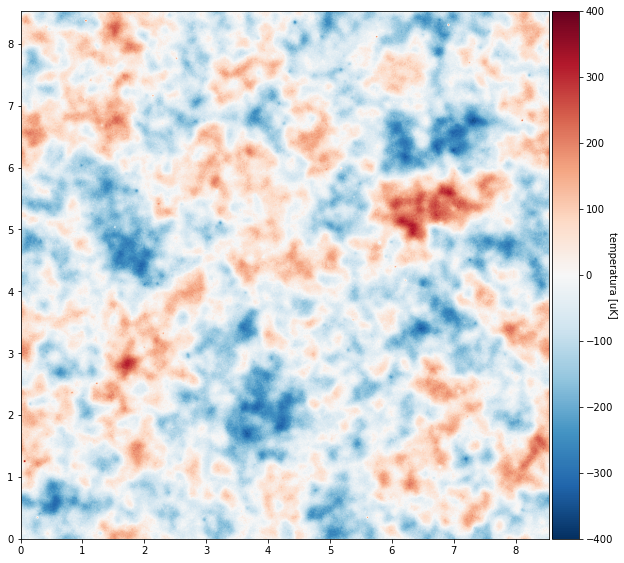

In [2]:
## Hacer un mapa CMB
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalCls.dat", usecols=(0, 1), unpack=True) 
CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)

N=int(N)
## hacer un mapa de fuentes puntuales
MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
MapaFP +=  componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)

## hacer un mapa SZ
MapaSZ,catSZ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,Amplitud_promedio_de_cumulos_SZ,
                                   SZ_beta,SZ_Theta_central,False)

## agregar todos juntos para obtener el mapa del cielo en una sola frecuencia
mapa_total = CMB_T + MapaFP + MapaSZ

## incorporar el impacto del instrumento
    ## haz
CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,mapa_total)
    ## ruido
Ruido = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)

mapa_total_mas_ruido = CMB_T_convolucionado + Ruido

mapa_total_mas_ruido_original = mapa_total_mas_ruido

catSZ_original = catSZ

## graficar el resultado
p=Graficar_Mapa_CMB(mapa_total_mas_ruido,c_min,c_max,X_ancho,Y_ancho)

## we will need a window funciton below, so we creat that here
ventana = (ventana_coseno(N))


Algunas fuentes puntuales y SZ son visibles en nuestro mapa simulado, sin embargo, hay muchas que son tenues y difíciles de identificar. Existen técnicas sofisticadas para aislar estas fuentes. Ahora discutiremos la técnica de filtro adaptado.


### Construcción de un filtro adaptado

Construimos un filtro adaptado de una sola frecuencia siguiendo a Melin etc... El punto clave es que construimos el siguiente filtro en el espacio de Fourier:

$$\psi = \frac{B_\ell S_\ell }{B_\ell^2 N^2_{ap,\ell} +N^2_{ins,\ell} } $$

Tanto $\psi$ como todas las demás cantidades son bidimensionales ya que dependen de $k_x$ y $k_y$. Nos referimos a estas coordenadas con $\ell$ como forma abreviada. En esta ecuación, $B_\ell$ es la transformada de Fourier del patrón del haz y el filtrado; $S_\ell$ es la transformada de Fourier de la plantilla de señal; $N^2_{ap,\ell}$ es el espectro de potencia (por ejemplo, el valor absoluto al cuadrado de la 2d FFT) del ruido astrofísico de fuentes distintas a las que se desea encontrar, y $N^2_{ins,\ ell}$ es el espectro de potencia de la respuesta instrumental.

En el siguiente cuadro definimos una función para calcular el filtro adaptado y una función para graficar el mapa resultante. En cuadros posteriores hacemos el trabajo de estimar los términos en el filtro.


In [3]:
def filtro_adaptado(mapa_entrada,haz_y_filt,perfil_señal,TF_covar_ruido):
    ## mapa_entrada: el mapa que estamos procesando
    ## haz_y_filt: el haz convolucionado con cualquier filtrado del mapa, en espacio real
    ## perfil_señal: la forma de la señal que estamos buscando, en espacio real
    ## TF_covar_ruido: el factor B N_{ap}^2 + N_{ins}^2 en espacio de Fourier
       ## calcular TF_covar_ruido toma tiempo por lo que lo hacemos de forma externa
    
    TF_haz_y_filt = np.fft.fft2(np.fft.fftshift(haz_y_filt))  ## transforma haz_y_filt a espacio Fourier
    TF_señal = np.fft.fft2(np.fft.fftshift(perfil_señal))     ## transforma el perfil del cumulo a Fourier
    
    psi = TF_haz_y_filt * TF_señal / TF_covar_ruido           ## definición de la función filtro adaptado
    
    filtrado = psi * np.fft.fft2(np.fft.fftshift(mapa_entrada))     ## filtrar el mapa
    filtrado = np.fft.fftshift(np.fft.ifft2(filtrado))              ## centrar el filtro
    filtrado = np.real(filtrado)                                    ## cambiar el tipo de datos a real
    return(filtrado)


def Graficar_Mapa_Filtrado(Mapa_a_Graficar,X_ancho,Y_ancho):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    print("promedio del mapa:",np.mean(Mapa_a_Graficar),"rms del mapa:",np.std(Mapa_a_Graficar))
    plt.figure(figsize=[10,10])
    im = plt.imshow(Mapa_a_Graficar, interpolation='bilinear', origin='lower',cmap=cm.RdBu_r)
    #im.set_clim(c_min,c_max)
    ax=plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    im.set_extent([0,X_ancho,0,Y_ancho])
    plt.ylabel('angulo $[^\circ]$')
    plt.xlabel('angulo $[^\circ]$')
    cbar.set_label('filtro_adaptado [Señal/Ruido]', rotation=270)
    plt.show()
    return(0)
  ###############################

Siguiendo lo que hicimos anteriormente para calcular el espectro de potencia, calcularemos la covarianza del ruido (el denominador de la definición de filtro coincidente) utilizando técnicas de Monte Carlo.

 realización de ruido para filtro adaptado, iteraciones completas: 16 de 16

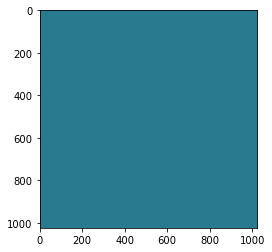

In [4]:
## construir la covarianza de ruido de ruido 2d en el espacio de Fourier
TF_covar_ruido = np.zeros((N,N))  ## un arreglo 2d para guardar el resultado
     
N_iteraciones = 16

## hacer una serie de mapas simulados, encontrar el espectro de potencia y promediarlos para estimar la covarianza
## del ruido
i = 0
while (i <N_iteraciones):
    ## simular el mapa astrofísico
    CMB_T = crear_mapa_CMB_T(N,tamaño_pix,ell,DlTT)
    MapaFP = componente_Poisson(N,tamaño_pix,Numero_de_Fuentes,Amplitud_de_Fuentes) 
    MapaFP +=  componente_Exponencial(N,tamaño_pix,Numero_de_Fuentes_EX,Amplitud_de_Fuentes_EX)
    MapaSZ,_ = componente_SZ(N,tamaño_pix,Numero_de_Cumulos_SZ,Amplitud_promedio_de_cumulos_SZ,
                                   SZ_beta,SZ_Theta_central,False)
    CMB_T  = CMB_T + MapaFP + MapaSZ  ## el mapa astrofísico
    
    ## agregando la respuesta del instrumento
    CMB_T_convolucionado = mapa_convolucionado_con_haz_gaussiano(N,tamaño_pix,tamaño_haz_fwhm,CMB_T)
    Ruido = hacer_mapa_de_ruido(N,tamaño_pix,nivel_de_ruido_blanco,nivel_de_ruido_atmosferico,nivel_de_ruido_1sobref)
    
    ## transformada de Fourier del mapa # estos son los dos terminos en el numerador
    temp =  np.fft.fft2(np.fft.fftshift(ventana* (CMB_T_convolucionado + Ruido)))

    ## tomamos el promedio
    TF_covar_ruido += np.real(np.conj(temp)*temp/(N_iteraciones*1.0))
    ## anotar el progreso
    sys.stdout.write("\r realización de ruido para filtro adaptado, iteraciones completas: %d de %d" % ((i+1),
                                                                                               N_iteraciones))
    sys.stdout.flush()
    ## iterar
    i = i + 1

Ahora que tenemos la covarianza del ruido y una función para calcular el filtro adaptado, filtramos nuestro mapa. Para interpretar este mapa, lo dividiremos por la desviación estándar del mapa filtrado para poner nuestro mapa en unidades de señal a ruido.

Puedes jugar con el número de iteraciones que usas en Monte Carlo del término de ruido. Si es demasiado pequeño, obtendrá un ringing de alta frecuencia.

promedio del mapa: -24.939713178679323 , media cuadrática (rms) del mapa: 96.71260395221331


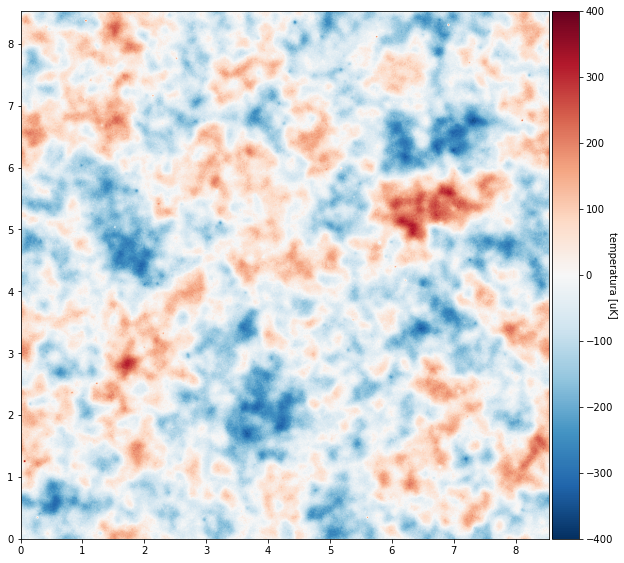

promedio del mapa: -0.0007820333520696919 rms del mapa: 1.0000000000000002


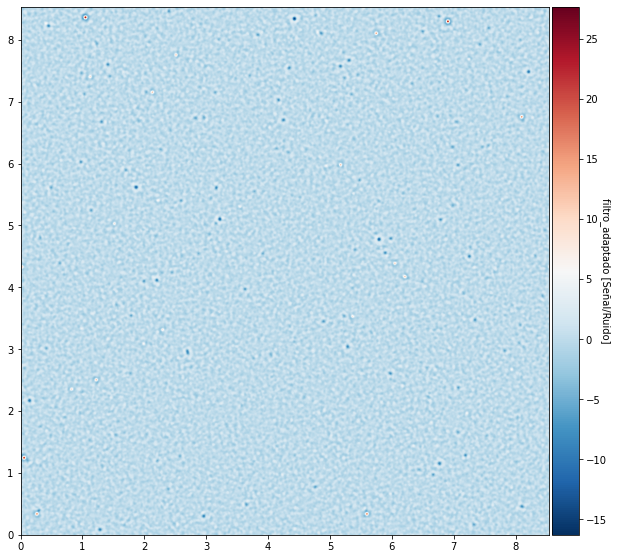

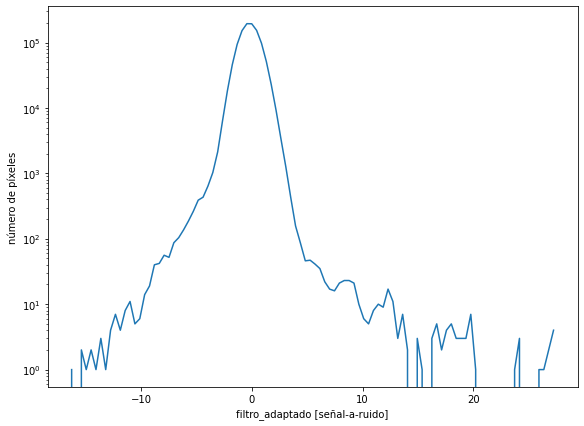

In [5]:
## construir el perfil del haz del telescopio y cúmulos de galaxias para el numerador del filtro adaptado
haz_y_filt = hacer_haz_gaussiano_2d(N,tamaño_pix,tamaño_haz_fwhm)  ## este es el filtrado que hicimos en el mapa
perfil_del_cumulo = funcion_beta(N,tamaño_pix,SZ_beta,SZ_Theta_central) ## está es la señal que estamos buscando

## Aplicar el filtro adaptado a nuestro mapa
mapa_filtrado = filtro_adaptado(mapa_total_mas_ruido_original,haz_y_filt,perfil_del_cumulo,TF_covar_ruido)

## hacer un mapa de Señal a Ruido / Signal-to-Noise (S/N)
mapa_SN = mapa_filtrado/np.std(mapa_filtrado)

## hacer algunos graficos
p = Graficar_Mapa_CMB(mapa_total_mas_ruido,c_min,c_max,X_ancho,Y_ancho)
p = Graficar_Mapa_Filtrado(mapa_SN,X_ancho,Y_ancho)

plt.figure(figsize=(9.5,7))

hist,bin_bordes = np.histogram(mapa_SN,bins = 100,range=[mapa_SN.min(),mapa_SN.max()])
plt.semilogy(bin_bordes[0:-1],hist)
plt.ylabel('número de píxeles')
plt.xlabel('filtro_adaptado [señal-a-ruido]')
plt.show()

Aquí mostramos tres mapas: (arriba) el mapa simulado sin procesar, (centro) el mapa filtrado y (abajo) un histograma de la señal-a-ruido de cada píxel en el mapa de filtro adaptado. Es posible identificar las fuentes SZ haciendo un corte en señal-a-ruido, por ejemplo tomando todos los píxeles que sean menores a -5. Para encontrar fuentes puntuales tenemos que reemplazar la función beta en la definición del filtro con una función delta y repetir el ejercicio buscando una señal-a-ruido por ejemplo mayor a 5.

NOTA: El corte en señal-a-ruido de $5 \sigma$ no es sagrado. Se elige de forma que la probabilidad de detección de un cúmulo espurio (o fuente puntual) sea baja en un parche de aproximadamente 100 grados cuadrados con una resolución de un minuto de arco. Dependiendo de la aplicación este corte puede ser ajustado.


<font color='red'>EJERCICIO: </font> Vuelve a correr este código pero con diferentes radios de cúmulos en el mapa de la parte dos que tiene multiples radios de cúmulos y ve como la señal-a-ruido varía para los diferentes cúmulos.

In [6]:
## Tu código y tus gráficos van aquí

comenta sobre tus resultados aquí

<font color='red'>EJERCICIO: </font> Crea un filtro adaptado para fuentes puntuales. Compara la señal-a-ruido para cúmulos SZ y para fuentes puntuales entre este mapa filtrado y el mapa filtrado SZ.

In [7]:
## Tu código y tus gráficos van aquí

comenta sobre tus resultados aquí

<font color='red'>EJERCICIO: </font>  Extrae una lista de fuentes con el siguiente procedimiento: (1) Buscar la señal-a-ruido más alta en la detección cúmulos, (2) Establecer los píxeles en cero dentro de un radio de ese cúmulo, y (3) Iterar hasta alcanzar un límite en señal-a-ruido. Comparar la lista de fuentes extraidas con el catalogo catSZ de las fuentes reales en la simulación.

In [8]:
## Tu código y tus gráficos van aquí

comenta sobre tus resultados aquí

## Apilamiento (Stacking)

A menudo, uno quiere entender las señales en el extremo de baja masa y, por lo tanto, baja señal a ruido. Si existe un catálogo externo, se pueden coagregar las señales de los objetos en el catálogo externo para aumentar la señal a ruido. En este ejemplo, apilamos el mapa observado simulado y el mapa filtrado adaptado en las posiciones de los grupos que colocamos en la simulación. Esto destaca las oportunidades que existen con el apilamiento.

La interpretación de estos resultados requiere un análisis cuidadoso. Las simulaciones Monte Carlo que incluyen efectos de selección y efectos sistemáticos son un enfoque particularmente atractivo.

promedio del mapa: -23.39473971247904 , media cuadrática (rms) del mapa: 5.179778743264607


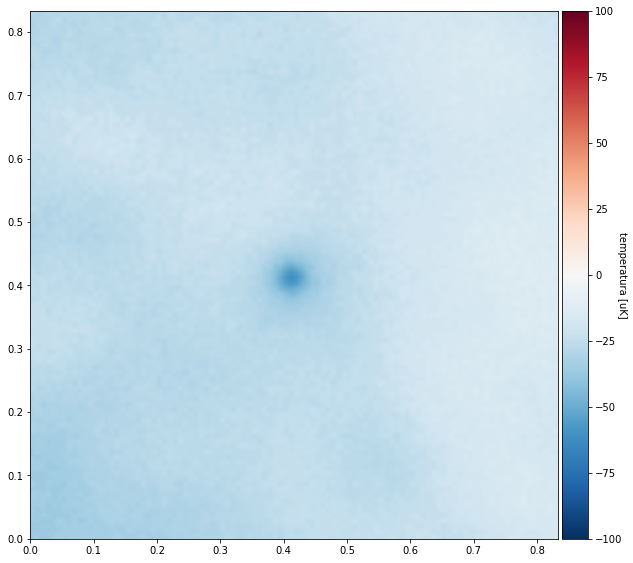

promedio del mapa: -0.0006632940616913302 rms del mapa: 0.121919589051763


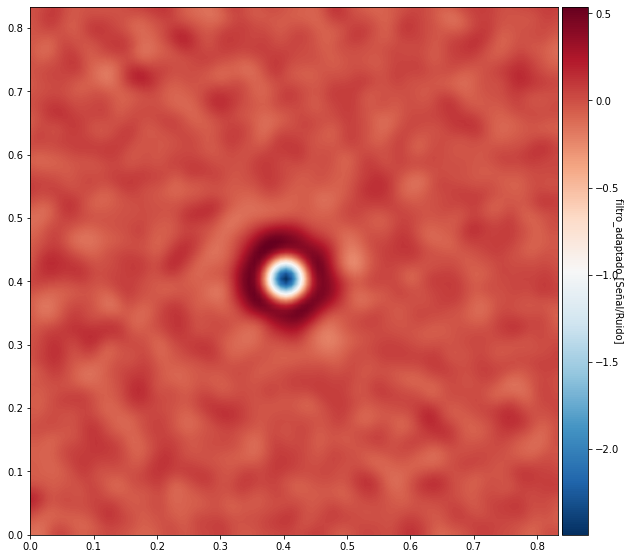

In [9]:
## toma catSZ y apile mapa_total_mas_ruido en las posiciones SZ, lo hace en un contenedor (bin) masivo
def Apilado_en_Posiciones(mapa,N,cat,N_objetos,bin_min,bin_max,Radio):
    Radio = int(Radio)
    apilado = np.zeros([Radio*2,Radio*2])
    contador = 0
    i = 0
    while (i < N_objetos):
        ampl = cat[2,i]
        if ((ampl > bin_min) and (ampl <= bin_max)):
            xc = cat[0,i]
            yc = cat[1,i]
            if ((xc > Radio) and (xc < N-Radio)):
                if ((yc > Radio) and (yc < N-Radio)):
                    
                    apilado += mapa[int(xc-Radio):int(xc+Radio),int(yc-Radio):int(yc+Radio)]
                    contador +=1
        i = i + 1
    return(apilado/contador)



apilado = Apilado_en_Posiciones(mapa_total_mas_ruido,N,catSZ,Numero_de_Cumulos_SZ,-100000,100000,50)
apilado_SN = Apilado_en_Posiciones(mapa_SN,N,catSZ,Numero_de_Cumulos_SZ,-100000,100000,50)

p = Graficar_Mapa_CMB(apilado,c_min/4.,c_max/4.,X_ancho*50*2/N,Y_ancho*50*2/N)
p2 = Graficar_Mapa_Filtrado(apilado_SN,X_ancho*50*2/N,Y_ancho*50*2/N)

El gráfico superior muestra el mapa de temperatura CMB apilado en las ubicaciones de los cúmulos SZ. El gráfico inferior muestra el mismo ejercicio de apilamiento repetido en el mapa filtrado.

<font color='red'>EJERCICIO: </font>  En este ejercicio, calcularas la señal SZ versus la amplitud de entrada por debajo del umbral S/N 5 en los mapas. Esto es similar a calcular una relación de escala SZ a partir de cúmulos seleccionados en óptico o rayos-x

Para hacer esto, divide el grupo en bins de "amplitud SZ" (la tercera columna del catSZ), calcula el peak del mapa apilado (CMB y S/N) para este bin de amplitud. Encuentra un método para estimar la punta de esta pila. Grafica la señal SZ recuperada versus la amplitud real.


In [10]:
## Tus códigos y gráficos van aquí

comenta sobre tus resultados aquí

### Errores de centrado

En este ejemplo introduciremos errores en las posiciones de los cúmulos en el catálogo. Es claro que la señal del cúmulo se ensanchara y desvanece.


promedio del mapa: -24.160832706417494 , media cuadrática (rms) del mapa: 5.057940015066173


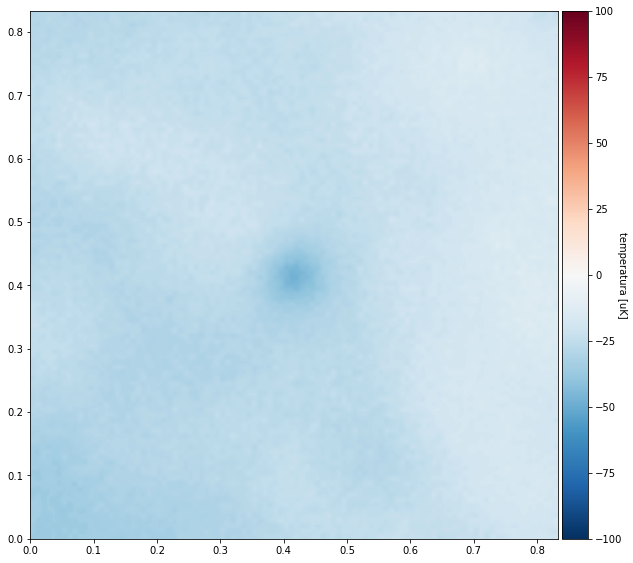

In [11]:

error_de_centrado_x = np.random.normal(0,2,Numero_de_Cumulos_SZ)
error_de_centrado_y = np.random.normal(0,2,Numero_de_Cumulos_SZ)
catSZ_error_centrado = catSZ
catSZ_error_centrado[0,:]  += error_de_centrado_x
catSZ_error_centrado[1,:]  += error_de_centrado_y

apilado = Apilado_en_Posiciones(mapa_total_mas_ruido,N,catSZ_error_centrado,Numero_de_Cumulos_SZ,-100000,100000,50)
p = Graficar_Mapa_CMB(apilado,c_min/4.,c_max/4.,X_ancho*50*2/N,Y_ancho*50*2/N)



<font color='red'>EJERCICIO: </font> Repita el ejercicio 18 con este error de centrado activado. Compara los resultados. Este es un excelente ejemplo de sistemáticos que deben tenerse en cuenta para extraer relaciones de escalado SZ a través del apilamiento.


In [12]:
## Tu código y tus gráficos van aquí

comenta sobre tus resultados aquí

## Correlaciones-cruzadas entre mapas ópticos y de CMB

Una alternativa al apilamiento es la correlación cruzada. Por ejemplo, uno puede tomar un catálogo óptico, hacer un mapa con la misma pixelización que el mapa CMB o la densidad de las fuentes (o la suma de las masas u otra propiedad), suavizar ese mapa y tomar el espectro de potencia usando las técnicas que usamos para Análisis CMB.

<font color='red'>EJERCICIO: </font>  Haz esto.


In [13]:
## Tu código va aquí

tus comentarios van aquí